In [75]:
import tensorflow as tf

import datetime as dt

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import one_hot
import texthero as hero
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

In [76]:
dataset = pd.read_csv('..\Datasets\Emotion_final.csv')

In [77]:
dataset['clean_text'] = hero.clean(dataset['Text'])
dataset['encoded_emotion'] = dataset['Emotion'].map({'sadness':0, 'anger':1, 'love':2, 'surprise':3, 'fear':4, 'happy':5})

In [78]:
X_train, X_test, = train_test_split(dataset, test_size= 0.2, random_state=111)

In [79]:
X_train, X_val = train_test_split(X_train, test_size = 0.3, random_state= 42)

In [80]:
dataset

,Text,Emotion,clean_text,encoded_emotion
0,i didnt feel humiliated,sadness,didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,sadness,go feeling hopeless damned hopeful around some...,0
2,im grabbing a minute to post i feel greedy wrong,anger,im grabbing minute post feel greedy wrong,1
3,i am ever feeling nostalgic about the fireplac...,love,ever feeling nostalgic fireplace know still pr...,2
4,i am feeling grouchy,anger,feeling grouchy,1
...,...,...,...,...
21454,Melissa stared at her friend in dism,fear,melissa stared friend dism,4
21455,Successive state elections have seen the gover...,fear,successive state elections seen governing part...,4
21456,Vincent was irritated but not dismay,fear,vincent irritated dismay,4
21457,Kendall-Hume turned back to face the dismayed ...,fear,kendall hume turned back face dismayed coup,4


In [81]:
from sklearn.utils import class_weight

class_weights = list(class_weight.compute_class_weight(class_weight ='balanced', 
                                     classes = np.unique(dataset['Emotion']), 
                                     y = dataset['Emotion']))

In [82]:
dataset['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [83]:
class_weights.sort()

In [84]:
class_weights

[0.5088206003698962,
 0.5708699122106944,
 1.194954894754427,
 1.348604826546003,
 2.179463741620963,
 4.068828213879408]

In [85]:
weights = {}

In [86]:
for index, weight in enumerate(class_weights):
    weights[index] = weight

In [87]:
weights

{0: 0.5088206003698962,
 1: 0.5708699122106944,
 2: 1.194954894754427,
 3: 1.348604826546003,
 4: 2.179463741620963,
 5: 4.068828213879408}

In [88]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train['clean_text'].values, X_train['Emotion'].values))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test['clean_text'].values, X_test['Emotion'].values))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val['clean_text'].values, X_val['Emotion'].values))

In [89]:
vocab_size = 40000
embedding_dim = 128
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [90]:
training_sentences = X_train.clean_text.to_list()
val_sentences = X_val.clean_text.to_list()
test_sentences = X_test.clean_text.to_list()

training_labels = np.array(X_train.encoded_emotion.to_list())
val_labels = np.array(X_val.encoded_emotion.to_list())
test_labels = np.array(X_test.encoded_emotion.to_list())


In [91]:
ohe = [one_hot(words, vocab_size) for words in training_sentences]
sent_length = 120
embedded_docs = pad_sequences(ohe, padding='pre', maxlen=sent_length)

ohe_val = [one_hot(words, vocab_size) for words in val_sentences]
sent_length = 120
embedded_val = pad_sequences(ohe_val, padding='pre', maxlen=sent_length)

ohe_test = [one_hot(words, vocab_size) for words in test_sentences]
sent_length = 120
embedded_test = pad_sequences(ohe_test, padding='pre', maxlen=sent_length)

In [145]:
embed_dim = 128
lstm_out = 192
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, BatchNormalization
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(BatchNormalization())
model.add(SpatialDropout1D(0.4))
model.add(BatchNormalization())
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(BatchNormalization())
model.add(Dense(6,activation='softmax'))

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
# for units in [128,128,64,32]:
#     model.add(tf.keras.layers.Dense(units, activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 120, 128)          5120000   
                                                                 
 batch_normalization (BatchN  (None, 120, 128)         512       
 ormalization)                                                   
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 120, 128)         0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_1 (Batc  (None, 120, 128)         512       
 hNormalization)                                                 
                                                                 
 lstm_5 (LSTM)               (None, 192)               246528    
                                                      

In [146]:
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

In [94]:
embedded_docs

array([[    0,     0,     0, ..., 38557, 22349, 17729],
       [    0,     0,     0, ..., 12976, 15744, 21977],
       [    0,     0,     0, ...,  2378, 16641, 19068],
       ...,
       [    0,     0,     0, ..., 35761, 32604, 17749],
       [    0,     0,     0, ..., 36513, 30925, 15714],
       [    0,     0,     0, ...,  8125, 37957, 32218]])

In [95]:
embedded_docs.shape

(12016, 120)

In [96]:
training_labels

array([0, 5, 0, ..., 2, 3, 2])

In [97]:
training_labels.shape

(12016,)

In [147]:
history = model.fit(embedded_docs, training_labels,
                    epochs=10,
                    validation_data = (embedded_val, val_labels),
                    verbose = 1, class_weight = weights
                    )

Epoch 1/10
376/376 [==============================] - 157s 413ms/step - loss: 2.7935 - accuracy: 0.3107 - val_loss: 1.7025 - val_accuracy: 0.4042
Epoch 2/10
376/376 [==============================] - 149s 397ms/step - loss: 1.6181 - accuracy: 0.4517 - val_loss: 1.2128 - val_accuracy: 0.6127
Epoch 3/10
376/376 [==============================] - 149s 395ms/step - loss: 0.8819 - accuracy: 0.6664 - val_loss: 0.5446 - val_accuracy: 0.8282
Epoch 4/10
376/376 [==============================] - 146s 389ms/step - loss: 0.5044 - accuracy: 0.8273 - val_loss: 0.3887 - val_accuracy: 0.8754
Epoch 5/10
376/376 [==============================] - 156s 414ms/step - loss: 0.3260 - accuracy: 0.8951 - val_loss: 0.3462 - val_accuracy: 0.8851
Epoch 6/10
376/376 [==============================] - 165s 438ms/step - loss: 0.2670 - accuracy: 0.9148 - val_loss: 0.4133 - val_accuracy: 0.8800
Epoch 7/10
376/376 [==============================] - 155s 413ms/step - loss: 0.2113 - accuracy: 0.9303 - val_loss: 0.3275 -

In [148]:

results = model.evaluate(embedded_test, test_labels, verbose=1)

print(results)

135/135 [==============================] - 17s 125ms/step - loss: 0.3603 - accuracy: 0.9010
[0.36029109358787537, 0.9009785652160645]


In [149]:
y_pred = model.predict(embedded_test)

In [150]:
from sklearn.metrics import classification_report

In [151]:
print(classification_report(test_labels, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1253
           1       0.90      0.85      0.87       630
           2       0.88      0.75      0.81       341
           3       0.89      0.66      0.76       170
           4       0.82      0.93      0.87       465
           5       0.89      0.96      0.92      1433

    accuracy                           0.90      4292
   macro avg       0.89      0.85      0.86      4292
weighted avg       0.90      0.90      0.90      4292



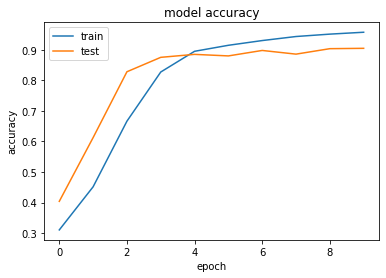

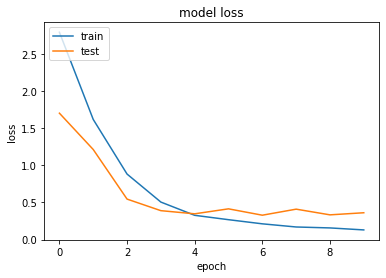

In [152]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [154]:
test = 'I am not sad'
ohe_trial = [one_hot(test, vocab_size)]
embed = pad_sequences(ohe_trial, padding='pre', maxlen=max_length)

In [155]:
pred = model.predict(embed)

In [156]:
classes = np.argmax(pred, axis = 1) 
print(classes)

[0]


In [106]:
model.save('../model/NLP')

INFO:tensorflow:Assets written to: ../model/NLP\assets


In [107]:

def text_analysis(text):
    model =load_model("../model/NLP.h5")
    ohe_trial = [one_hot(text, vocab_size)]
    embed = pad_sequences(ohe_trial, padding='pre', maxlen=max_length)
    pred = model.predict(embed)
    classes = list(np.argmax(pred, axis = 1))
    if classes == [0]:
        return 'Sad'
    if classes == [1]:
        return 'Angry'
    if classes == [2]:
        return 'Love'
    if classes == [3]:
        return 'Surprise'
    if classes == [4]:
        return 'Fear'
    else:
        return 'Happy'


    

In [108]:
import h5py
import numpy as np

print(text_analysis('Hello, nice to see you'))

Love


In [157]:
tf.keras.models.save_model(model=model, filepath='model', save_format='tf')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


In [134]:
model_test = load_model("model")